In [1]:
import torch.optim as optim
from torch.utils.data import DataLoader
from livelossplot import PlotLosses

In [2]:
class Vocab:
    
    def __init__(self, word_set):
        self.words = ['<pad>', '<eos>']+list(sorted(word_set))
        self.map = dict()
        
        for i, word in enumerate(self.words):
            self.map[word] = i
            
            
    def atoi(self, word):
        
        return self.map[word]
    
    def itoa(self, idx):
        return self.words[idx]

In [3]:
v = Vocab(set(['a','b', 'c']))

In [4]:
from allograph.config import AllographConfig


def read_dataset(lang_id='eng'):

    r = open(AllographConfig.lang_path / lang_id / 'new_input', 'r')

    phoneme_lst = []
    grapheme_lst = []
    
    phoneme_set = set()
    grapheme_set = set()

    for line in r:
        phoneme_str, grapheme_str = line.strip().split('\t')
        phonemes = phoneme_str.split()
        graphemes = grapheme_str.split()
        phoneme_lst.append(phonemes)
        grapheme_lst.append(graphemes)
        phoneme_set.update(phonemes)
        grapheme_set.update(graphemes)
        
    phoneme_vocab = Vocab(phoneme_set)
    grapheme_vocab = Vocab(grapheme_set)
    
    return Dataset(phoneme_lst, grapheme_lst, phoneme_vocab, grapheme_vocab)


class Dataset:

    def __init__(self, phoneme_lst, grapheme_lst, phoneme_vocab, grapheme_vocab):

        self.phoneme_lst = phoneme_lst
        self.grapheme_lst = grapheme_lst
        self.phoneme_vocab = phoneme_vocab
        self.grapheme_vocab = grapheme_vocab

    def __getitem__(self, item):
        
        phones = self.phoneme_lst[item]
        graphemes = self.grapheme_lst[item]
        
        phone_ids = [self.phoneme_vocab.atoi(phone) for phone in phones]
        grapheme_ids = [self.grapheme_vocab.atoi(grapheme) for grapheme in graphemes]
        

        return (torch.LongTensor(phone_ids), torch.LongTensor(grapheme_ids))

    def __len__(self):
        return len(self.phoneme_lst)

In [5]:
data = read_dataset()

In [6]:
len(data.phoneme_vocab.map)

166

In [7]:
data[0]

(tensor([66, 69, 60, 56, 65, 71]), tensor([28, 33, 32, 29, 14, 18]))

In [12]:
def collate(xy_lst):
    x_lst = [xy[0] for xy in xy_lst]
    y_lst = [xy[1] for xy in xy_lst]
    
    x = pad_list(x_lst)
    y = pad_list(y_lst)
    
    return x,y
    
def pad_list(tensor_lst):
    max_length = max(t.size(0) for t in tensor_lst)
    batch_size = len(tensor_lst)
    
    padded_tensor = tensor_lst[0].new(batch_size, max_length, *tensor_lst[0].size()[1:]).fill_(0)
    for i, t in enumerate(tensor_lst):
        padded_tensor[i,:t.size(0)] = t
        
    return padded_tensor

In [9]:
loader = DataLoader(data, shuffle=True, batch_size=8, collate_fn=collate)

In [10]:
it = iter(loader)

In [13]:
next(it)

(tensor([[26, 63, 54, 52, 77, 52, 69,  0,  0],
         [55, 69, 52, 72, 58, 59, 71, 70,  0],
         [54, 59, 66, 63, 66,  0,  0,  0,  0],
         [57, 60, 77, 58, 60, 58,  0,  0,  0],
         [56, 67, 59, 56, 64, 56, 69, 52, 63],
         [55, 60, 66, 67, 71, 69, 60, 54,  0],
         [57, 63, 56, 52, 64,  0,  0,  0,  0],
         [58,  6, 65, 60, 58, 59, 71,  0,  0]]),
 tensor([[ 2, 12, 11, 29, 23, 27,  0,  0,  0],
         [ 4, 33, 27,  7,  2,  0,  0,  0,  0],
         [19, 15, 36, 12, 15, 36,  0,  0,  0],
         [ 7, 32, 23, 31, 32, 31,  0,  0,  0],
         [30,  7, 30, 13, 29, 33, 29, 12,  0],
         [ 4,  2, 32, 15, 16, 18, 33, 32, 11],
         [ 7, 12,  9, 13,  0,  0,  0,  0,  0],
         [31, 29, 14,  2, 32, 18,  0,  0,  0]]))

In [31]:
class Encoder(nn.Module):
    
    def __init__(self, vocab_size, hidden_size, layer_size):
        super().__init__()
        
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, layer_size, batch_first=True)
        
    def forward(self, input_tensor):
        embed = self.embed(input_tensor)
        output, (hidden, _) = self.rnn(embed)
        
        return output, hidden
    
    
class Decoder(nn.Module):
    
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, 1, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.logsoftmax = nn.LogSoftmax(dim=2)
        
    def forward(self, input_tensor, prev_hidden, prev_cell):
        # input: [B]
        
        embed = self.embed(input_tensor)
        output, (hidden, cell) = self.rnn(embed, (prev_hidden, prev_cell))
        #print('after rnn', output)
        output = self.linear(output)
        #print('after linear:', output)
        output = self.logsoftmax(output)
        #print('after softmax', output)
        
        return output, hidden, cell

class G2P(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.encoder = Encoder(200, 128, 1)
        self.decoder = Decoder(200, 128)     

In [15]:
def pad_sos_eos(ys, sos, eos):
    
    batch_size = len(ys)

    sos_tensor = ys.new_zeros((batch_size, 1)).fill_(sos)
    y_in = torch.cat([sos_tensor, ys], dim=1)
    
    y_out = []
    
    zero_tensor = ys.new_zeros((batch_size, 1))    
    extended_ys = torch.cat([ys, zero_tensor], dim=1)
    
    for y in extended_ys:
        eos_idx = (y==0).nonzero()[0].item()
        y[eos_idx] = eos        
        y_out.append(y)
        
    y_out = pad_list(y_out)
    return y_in, y_out

In [16]:
it = iter(loader)
batch = next(it)

In [17]:
batch

(tensor([[52, 74, 57, 72, 63,  0,  0,  0,  0,  0,  0,  0],
         [64, 66, 71, 59, 53, 52, 63, 63, 56, 55,  0,  0],
         [70, 67, 52, 71, 60, 52, 71, 56,  0,  0,  0,  0],
         [69, 56, 56, 55,  0,  0,  0,  0,  0,  0,  0,  0],
         [60, 65, 71, 56, 65, 71, 60, 73, 56,  0,  0,  0],
         [52, 55, 61, 66, 60, 65, 56, 55,  0,  0,  0,  0],
         [64, 56, 71, 52, 64, 66, 69, 67, 59, 60, 70, 64],
         [70, 59, 56, 56, 69,  0,  0,  0,  0,  0,  0,  0]]),
 tensor([[28,  7, 36, 12,  0,  0,  0,  0,  0,  0,  0],
         [13, 15, 39,  3, 28, 12,  4,  0,  0,  0,  0],
         [17, 16,  6, 32, 35,  9,  6, 32, 18,  0,  0],
         [33,  9,  4,  0,  0,  0,  0,  0,  0,  0,  0],
         [32, 14, 18, 30, 14, 18, 32, 21,  0,  0,  0],
         [29,  5, 28, 32, 14,  4,  0,  0,  0,  0,  0],
         [13, 30, 18, 29, 13, 28,  7, 32, 23, 29, 13],
         [35, 32, 29,  0,  0,  0,  0,  0,  0,  0,  0]]))

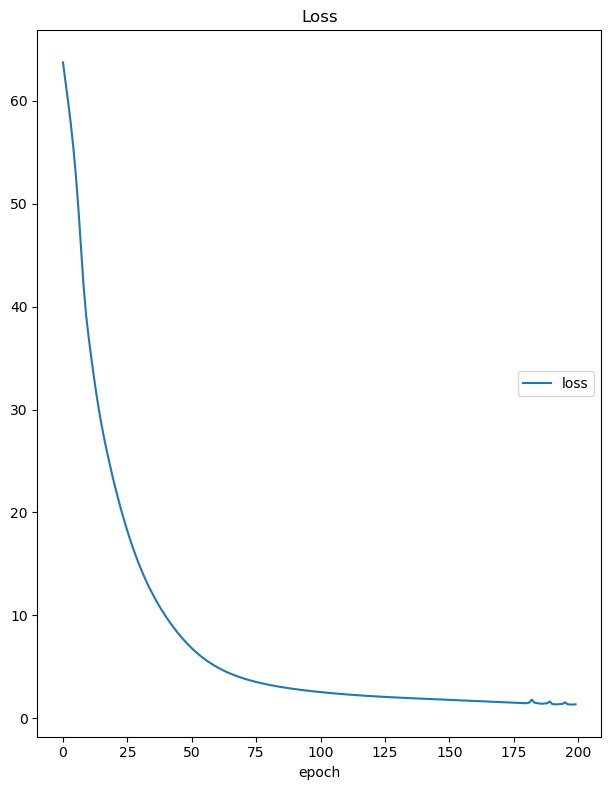

Loss
	loss             	 (min:    1.320, max:   63.735, cur:    1.352)


In [41]:
model = G2P()
opt = optim.SGD(model.parameters(), lr=0.05)
criterion = nn.NLLLoss(ignore_index=0)

#it = iter(loader)

liveloss = PlotLosses()

for i in range(200):

    #batch = next(it)
    x, y = batch
    #print(x[0])
    #print(y[0])
    batch_size = x.shape[0]

    output, prev_hidden = model.encoder(x)
    prev_cell = x.new_zeros(1, batch_size, 128)

    ys_in, ys_out = pad_sos_eos(y, 1, 1)
    ys_in = ys_in.transpose(1,0)
    ys_out = ys_out.transpose(1,0)

    opt.zero_grad()
    
    loss = 0
    log = {}

    for i in range(len(ys_in)):
        y_in = ys_in[i].view(batch_size, 1)
        y_out = ys_out[i]
        output, prev_hidden, prev_cell = model.decoder(y_in, prev_hidden, prev_cell)

        output = output.squeeze()
        #print(y_out.shape)
        loss += criterion(output, y_out)

    loss.backward()
    opt.step()
    
    log['loss'] = loss.item()
    liveloss.update(log)
    liveloss.send()

In [20]:
a = torch.LongTensor([1,3,2])

In [23]:
a.topk(1)[1].item()

1

In [42]:
model.eval()

    
x = torch.LongTensor([[52, 74, 57, 72, 63,  0,  0,  0,  0,  0,  0,  0]])

batch_size = 1

output, prev_hidden = model.encoder(x)
prev_cell = prev_hidden.new_zeros((1, batch_size, 128))

#print(prev_hidden)

#y_in = torch.LongTensor([[1]])
y_out = []

w = 1

while(True):
    y_in = torch.LongTensor([[w]])
    output, prev_hidden, prev_cell = model.decoder(y_in, prev_hidden, prev_cell)
    output = output.squeeze()
    #print(output)
    w = output.data.topk(1)[1].item()
    y_out.append(w)
    
    if w == 1 or len(y_out)>10:
        break

print(y_out)

[28, 7, 36, 12, 1]


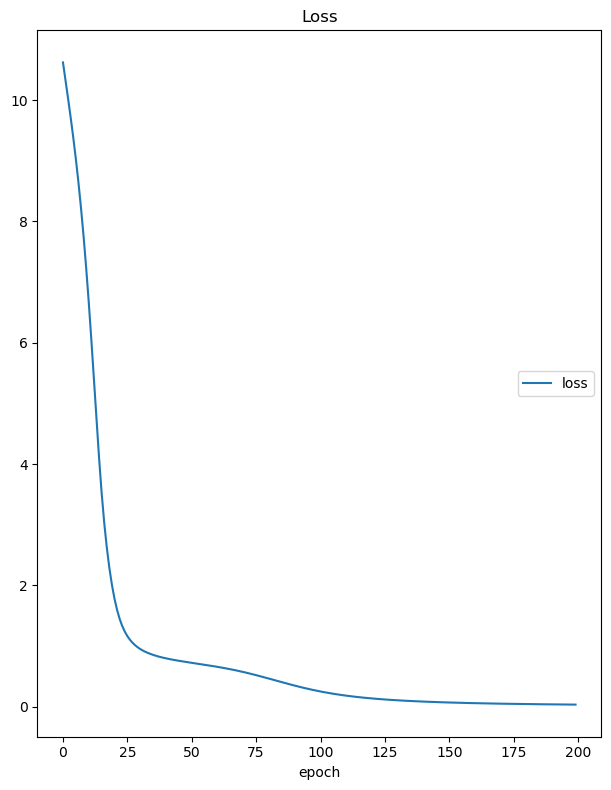

Loss
	loss             	 (min:    0.036, max:   10.621, cur:    0.036)


In [43]:
model = G2P()
opt = optim.SGD(model.parameters(), lr=0.05)
criterion = nn.NLLLoss(ignore_index=0)

#it = iter(loader)

liveloss = PlotLosses()

batch = (torch.LongTensor([[2], [3]]), torch.LongTensor([[2], [3]]))

for i in range(200):

    #batch = next(it)
    x, y = batch
    #print(x[0])
    #print(y[0])
    batch_size = x.shape[0]

    output, prev_hidden = model.encoder(x)
    prev_cell = x.new_zeros(1, batch_size, 128)

    ys_in, ys_out = pad_sos_eos(y, 1, 1)
    ys_in = ys_in.transpose(1,0)
    ys_out = ys_out.transpose(1,0)

    opt.zero_grad()
    
    loss = 0
    log = {}

    for i in range(len(ys_in)):
        y_in = ys_in[i].view(batch_size, 1)
        y_out = ys_out[i]
        output, prev_hidden, prev_cell = model.decoder(y_in, prev_hidden, prev_cell)

        output = output.squeeze()
        #print(y_out.shape)
        loss += criterion(output, y_out)

    loss.backward()
    opt.step()
    
    log['loss'] = loss.item()
    liveloss.update(log)
    liveloss.send()